In [6]:
import time
import copy
import sys
import pandas as pd
from collections import Counter
import ast
from sklearn.gaussian_process import kernels
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, matthews_corrcoef, balanced_accuracy_score, accuracy_score
import utils2
import matplotlib.pyplot as plt
import seaborn as sns

## Tensorization

In [7]:
MLM = 'NeuralNetwork2'
SCALE = 'StandardScaler'
# SCALE = 'MinMaxScaler'

randomSeed = 1
CPU_num = -1
N_repeat_KFold_paramTune = 1
N_repeat_KFold = 2000
info_shown = 1
Kfold = 5 # 5
Kfold_list = RepeatedKFold(n_splits=Kfold,
                           n_repeats=N_repeat_KFold,
                           random_state=randomSeed)
randomSearchNumber = 1
phenoNA = 'Response'

featuresNA = ['TMB', 'Systemic_therapy_history', 'Albumin', 'FCNA', 'NLR',
              'Age','Drug', 'Sex', 'MSI', 'Stage', 'HLA_LOH', 'HED', 'Platelets',
              'HGB', 'BMI', 'CancerType1', 'CancerType2', 'CancerType3',
              'CancerType4', 'CancerType5', 'CancerType6', 'CancerType7',
              'CancerType8', 'CancerType9', 'CancerType10', 'CancerType11',
              'CancerType12', 'CancerType13', 'CancerType14', 'CancerType15',
              'CancerType16'] # all 16 features

cat_features = []

In [3]:
dataALL_fn = '../02.Input/AllData.xlsx'
data_train = pd.read_excel(dataALL_fn, sheet_name='Chowell_train', index_col=0)
data_test = pd.read_excel(dataALL_fn, sheet_name='Chowell_test', index_col=0)

# Data truncation
TMB_upper = 50
Age_upper = 85
NLR_upper = 25
data_train['TMB'] = [c if c < TMB_upper else TMB_upper for c in data_train['TMB']]
data_train['Age'] = [c if c < Age_upper else Age_upper for c in data_train['Age']]
data_train['NLR'] = [c if c < NLR_upper else NLR_upper for c in data_train['NLR']]
counter = Counter(data_train[phenoNA])
pos_weight = counter[0] / counter[1]
print('  Number of all features: ', len(featuresNA), '\n  Their names: ', featuresNA)
print('  Phenotype name: ', phenoNA)
print('  Negative/Positive samples in training set: ', pos_weight)
print('Data size: ', data_train.shape[0])

data_test['TMB'] = [c if c < TMB_upper else TMB_upper for c in data_test['TMB']]
data_test['Age'] = [c if c < Age_upper else Age_upper for c in data_test['Age']]
data_test['NLR'] = [c if c < NLR_upper else NLR_upper for c in data_test['NLR']]

  Number of all features:  31 
  Their names:  ['TMB', 'Systemic_therapy_history', 'Albumin', 'FCNA', 'NLR', 'Age', 'Drug', 'Sex', 'MSI', 'Stage', 'HLA_LOH', 'HED', 'Platelets', 'HGB', 'BMI', 'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4', 'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8', 'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12', 'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16']
  Phenotype name:  Response
  Negative/Positive samples in training set:  2.4184397163120566
Data size:  964


In [4]:
data_train[featuresNA]

,TMB,Systemic_therapy_history,Albumin,FCNA,NLR,Age,Drug,Sex,MSI,Stage,...,CancerType7,CancerType8,CancerType9,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
1,4.9,1,3.8,0.0426,7.60,63.748118,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,4.1,0.6496,2.69,58.965092,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,6.1,1,3.9,0.2347,3.32,69.174538,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0,4.1,0.2317,5.21,53.659138,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,2.0,1,4.4,0.6802,2.18,61.787817,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,0.0,0,3.7,0.1617,2.48,71.975359,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
961,0.0,0,4.5,0.0000,1.73,60.711841,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
962,2.6,1,3.7,0.0793,3.29,67.041752,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [145]:
data_test[featuresNA]

,TMB,Systemic_therapy_history,Albumin,FCNA,NLR,Age,Drug,Sex,MSI,Stage,...,CancerType7,CancerType8,CancerType9,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
1,32.5,1,4.3,0.0120,1.19,67.915127,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,19.3,1,3.8,0.1190,1.38,62.502396,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,10.5,1,4.2,0.4627,2.54,52.106776,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,3.5,1,3.7,0.3729,4.89,61.987680,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
5,32.5,0,4.6,0.1008,4.00,85.000000,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,1.8,1,3.9,0.2324,3.41,67.238877,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
512,2.6,1,3.2,0.1980,5.73,71.906913,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
513,4.4,1,3.9,0.2809,4.00,73.817933,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [146]:
HyperParam_fnIn = '../03.Results/16features/PanCancer/ModelParaSearchResult_' + \
    MLM + '_Scaler(' + SCALE + ')_CV' + str(Kfold) + 'Rep' + \
        str(N_repeat_KFold_paramTune) + '_random' + str(randomSeed) + '.txt'
paramDict_line_str = 'Best params on CV sets:  '
for line in open(HyperParam_fnIn,'r').readlines():
    if line.startswith(paramDict_line_str):
        paramDict_str = line.strip().split(paramDict_line_str)[1]
        break
param_dict = ast.literal_eval(paramDict_str)
for c in param_dict:
    param_dict[c] = [param_dict[c]]

In [147]:
param_dict

{'max_iter': [100],
 'hidden_layer_sizes': [(19, 19)],
 'early_stopping': [False],
 'alpha': [1e-05],
 'activation': ['tanh']}

In [148]:
for key, value in param_dict.items():
    param_dict[key] = value[0]

param_dict['max_iter'] = 1000

param_dict

{'max_iter': 1000,
 'hidden_layer_sizes': (19, 19),
 'early_stopping': False,
 'alpha': 1e-05,
 'activation': 'tanh'}

In [149]:
def dataScaler(data, featuresNA, numeric_featuresNA, scaler_type):
    data_scaled = copy.deepcopy(data)
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMax':
        scaler = MinMaxScaler()
    else:
        raise Exception('Unrecognized scaler type of %s! Only "sd" and "mM" are accepted.' % scaler_type)
    for feature in numeric_featuresNA:
        data_scaled[feature] = scaler.fit_transform(data[[feature]])
    x = pd.DataFrame(data_scaled, columns=featuresNA)
    return x

In [150]:
y = data_train[phenoNA]
counter = Counter(y)
print(counter)

numeric_featuresNA = list(set(featuresNA) - set(cat_features))
# x = dataScaler(data_train, featuresNA, numeric_featuresNA, 'StandardScaler')
x = dataScaler(data_train, featuresNA, numeric_featuresNA, 'MinMax')

Counter({0: 682, 1: 282})


In [151]:
MLP = MLPClassifier(random_state=randomSeed, **param_dict)
MLP.fit(x.values, y.values)

/home/jose/anaconda3/envs/loris/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', alpha=1e-05, hidden_layer_sizes=(19, 19),
              max_iter=1000, random_state=1)

In [152]:
y_test = data_test[phenoNA]

numeric_featuresNA = list(set(featuresNA) - set(cat_features))
# x_test = dataScaler(data_test, featuresNA, numeric_featuresNA, 'StandardScaler')
x_test = dataScaler(data_test, featuresNA, numeric_featuresNA, 'MinMax')

In [153]:
train_acc = accuracy_score(y.values, MLP.predict(x.values))
test_acc = accuracy_score(y_test.values, MLP.predict(x_test.values))
print(train_acc, test_acc)

train_bal_acc = balanced_accuracy_score(y.values, MLP.predict(x.values))
test_bal_acc = balanced_accuracy_score(y_test.values, MLP.predict(x_test.values))
print(train_bal_acc, test_bal_acc)

0.8267634854771784 0.7320388349514563
0.7756546244878435 0.6208904943583083


In [154]:
import torch
import tensorkrowch as tk
from tensorkrowch.decompositions import tt_rss

x_torch = torch.from_numpy(x.values).float()
y_torch = torch.from_numpy(y.values)

x_test_torch = torch.from_numpy(x_test.values).float()
y_test_torch = torch.from_numpy(y_test.values)


sketch_size = 200
phys_dim = 3
domain = torch.linspace(x_torch.min(), x_torch.max(), phys_dim)
bond_dim = 10
cum_percentage = 0.99
batch_size = 500
device = torch.device('cpu')

In [155]:
# def fn_model(data):
#     result = torch.from_numpy(MLP.predict(data)).unsqueeze(-1)
#     result = tk.embeddings.basis(result, dim=2).squeeze(1).float()
#     return result

def fn_model(data):
    result = torch.from_numpy(MLP.predict_proba(data)).float()
    return result

In [156]:
def embedding(data):
    return tk.embeddings.poly(data, degree=phys_dim - 1)

# def embedding(data):
#     return tk.embeddings.unit(data, dim=phys_dim)

In [157]:
cores = tt_rss(function=fn_model,
               embedding=embedding,
               sketch_samples=x_torch[:sketch_size],
               labels=y_torch[:sketch_size],
               domain_multiplier=1,
               domain=domain,
               rank=bond_dim,
               cum_percentage=cum_percentage,
               batch_size=batch_size,
               device=device)



|| Site: 1 / 32 ||
* Max D_k: min(3, 10)
* T_k out dim: 200

Core 1:
-------
tensor([[-0.4443, -0.8798,  0.1689],
        [ 0.8076, -0.3117,  0.5007],
        [-0.3879,  0.3589,  0.8490]])
* Final D_k: 3
* S_k out dim: 49


|| Site: 2 / 32 ||
* Max D_k: min(9, 10)
* T_k out dim: 200

Core 2:
-------
tensor([[[-0.0924, -0.0324, -0.1178, -0.0060,  0.7981,  0.2365, -0.0282,
           0.8229,  1.2282],
         [-0.0495,  0.1293, -0.7936, -0.5297, -0.5514,  1.3749, -0.1061,
          -0.3390, -0.9616],
         [ 0.0355, -0.0941,  0.7155,  0.4434,  0.2690, -0.7614, -1.2288,
          -0.5596, -0.4518]],

        [[-0.0299, -0.1340,  0.0330, -0.0134, -0.1757, -0.0407,  0.0065,
          -0.3962, -0.5707],
         [-0.1223,  0.0139,  0.2108,  0.2083,  0.2333, -0.6370, -0.0820,
           0.1667,  0.4431],
         [ 0.0785,  0.0058, -0.3545, -0.0264, -0.1271,  0.4108,  0.4293,
           0.3166,  0.1773]],

        [[ 0.0068,  0.0015,  0.0247, -0.0275,  0.0960,  0.0444, -0.0034,
        

In [158]:
for t in cores:
    print(t.shape)

torch.Size([3, 3])
torch.Size([3, 3, 9])
torch.Size([9, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 2, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 10])
torch.Size([10, 3, 9])
torch.Size([9, 3, 8])
torch.Size([8, 3, 7])
torch.Size([7, 3, 7])
torch.Size([7, 3, 6])
torch.Size([6, 3, 5])
torch.Size([5, 3, 4])
torch.Size([4, 3, 3])
torch.Size([3, 3, 2])
torch.Size([2, 3])


In [159]:
mps = tk.models.MPSLayer(tensors=cores)
mps.trace(torch.zeros(1, 31, phys_dim))

In [160]:
y_pred_mps = mps(embedding(x_torch))
_, y_pred_mps = y_pred_mps.max(dim=1)
y_pred_mps

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [161]:
y_pred_mlp = MLP.predict(x_torch)
y_pred_mlp

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

In [162]:
def total_acc(y_true, y_pred):
    return (y_pred == y_true).sum() / len(y_true)

def balanced_acc(y_true, y_pred):
    acc_0 = (y_pred[y_true == 0] == y_true[y_true == 0]).sum() / \
        len(y_true[y_true == 0])
    acc_1 = (y_pred[y_true == 1] == y_true[y_true == 1]).sum() / \
        len(y_true[y_true == 1])
    return (acc_0 + acc_1) / 2

In [163]:
# MLP
y_pred_mlp = MLP.predict(x_torch)
print('MLP Train:',
      total_acc(y_torch, y_pred_mlp),
      balanced_acc(y_torch, y_pred_mlp))

y_test_pred_mlp = MLP.predict(x_test_torch)
print('MLP Test:',
      total_acc(y_test_torch, y_test_pred_mlp),
      balanced_acc(y_test_torch, y_test_pred_mlp))
print()

# MPS
y_pred_mps = mps(embedding(x_torch))
_, y_pred_mps = y_pred_mps.max(dim=1)
print('MPS Train:',
      total_acc(y_torch, y_pred_mps),
      balanced_acc(y_torch, y_pred_mps))

y_test_pred_mps = mps(embedding(x_test_torch))
_, y_test_pred_mps = y_test_pred_mps.max(dim=1)
print('MPS Test:',
      total_acc(y_test_torch, y_test_pred_mlp),
      balanced_acc(y_test_torch, y_test_pred_mlp))
print()

# % of same classifications by MPS and MLP
acc_approx = (y_pred_mps == y_pred_mlp).sum() / len(y_pred_mlp)
print('Accuracy MPS - MLP:', acc_approx)

MLP Train: tensor(0.8268) tensor(0.7757)
MLP Test: tensor(0.7320) tensor(0.6209)

MPS Train: tensor(0.7863) tensor(0.6961)
MPS Test: tensor(0.7320) tensor(0.6209)

Accuracy MPS - MLP: tensor(0.9118)


## Classify by datasets

In [8]:
data_survival_fn = '../02.Input/AllData.xlsx'

datasets = ['Chowell_train', 'Chowell_test', 'MSK1', 'MSK2', 'Shim_NSCLC',
            'Kato_panCancer', 'Vanguri_NSCLC', 'Ravi_NSCLC', 'Pradat_panCancer']

TMB_upper = 50
Age_upper = 85
NLR_upper = 25

dfs = []
for ds in datasets:
    df = pd.read_excel(data_survival_fn, sheet_name=ds, index_col=0)
    df['Dataset'] = ds
    
    # Data truncation
    df['TMB'] = [c if c < TMB_upper else TMB_upper for c in df['TMB']]
    df['Age'] = [c if c < Age_upper else Age_upper for c in df['Age']]
    df['NLR'] = [c if c < NLR_upper else NLR_upper for c in df['NLR']]
    
    dfs.append(df)

data_all_raw = pd.concat(dfs, axis=0)

In [25]:
data_all_raw[featuresNA]

,TMB,Systemic_therapy_history,Albumin,FCNA,NLR,Age,Drug,Sex,MSI,Stage,...,CancerType7,CancerType8,CancerType9,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
1,4.900000,1.0,3.8,0.0426,7.600000,63.748118,0.0,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1.000000,0.0,4.1,0.6496,2.690000,58.965092,1.0,0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
3,6.100000,1.0,3.9,0.2347,3.320000,69.174538,0.0,0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0
4,0.000000,0.0,4.1,0.2317,5.210000,53.659138,0.0,1,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
5,2.000000,1.0,4.4,0.6802,2.180000,61.787817,0.0,0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,3.150000,1.0,4.1,0.6939,3.333333,53.420000,0.0,0,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
54,4.200000,1.0,3.4,0.8623,3.050000,48.490000,0.0,0,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
55,5.631818,1.0,3.4,0.7836,11.500000,68.270000,0.0,1,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0


In [26]:
data_all_raw['Dataset'].value_counts()

Dataset
Chowell_train       964
Chowell_test        515
MSK1                453
Ravi_NSCLC          309
Vanguri_NSCLC       246
Shim_NSCLC          198
MSK2                104
Pradat_panCancer     57
Kato_panCancer       35
Name: count, dtype: int64

In [27]:
xy_colNAs = ['TMB', 'PDL1_TPS(%)', 'Systemic_therapy_history', 'Albumin', 'NLR',
             'Age', 'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
             'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
             'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
             'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16'] +\
             [phenoNA] + ['Dataset']

In [28]:
data_no_nans = data_all_raw[xy_colNAs].dropna(axis=0)
data_no_nans['Dataset'].value_counts()

Dataset
Chowell_train    217
Vanguri_NSCLC    201
Ravi_NSCLC       193
Chowell_test     187
Shim_NSCLC       144
MSK1              83
MSK2               6
Name: count, dtype: int64

In [29]:
data_no_nans

,TMB,PDL1_TPS(%),Systemic_therapy_history,Albumin,NLR,Age,CancerType1,CancerType2,CancerType3,CancerType4,...,CancerType9,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16,Response,Dataset
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
19,3.500000,60.0,0.0,3.8,2.33,85.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Chowell_train
29,2.000000,97.5,0.0,3.9,1.32,53.103354,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Chowell_train
38,1.800000,80.0,0.0,3.6,2.60,85.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Chowell_train
49,5.900000,0.0,1.0,4.0,2.95,50.658453,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Chowell_train
71,0.000000,0.0,1.0,4.3,25.00,45.360712,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chowell_train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,20.253333,10.0,1.0,3.8,6.20,66.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Ravi_NSCLC
304,12.810000,0.0,1.0,3.8,6.20,74.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Ravi_NSCLC
305,16.590000,0.0,1.0,3.8,6.20,63.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Ravi_NSCLC


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Encode text feature into integer values
label_encoder = LabelEncoder()
data_no_nans['DatasetNum'] = label_encoder.fit_transform(data_no_nans['Dataset'])

data_no_nans

,TMB,PDL1_TPS(%),Systemic_therapy_history,Albumin,NLR,Age,CancerType1,CancerType2,CancerType3,CancerType4,...,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16,Response,Dataset,DatasetNum
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
19,3.500000,60.0,0.0,3.8,2.33,85.000000,0,0,0,0,...,0,1,0,0,0,0,0,1,Chowell_train,1
29,2.000000,97.5,0.0,3.9,1.32,53.103354,0,0,0,0,...,0,1,0,0,0,0,0,1,Chowell_train,1
38,1.800000,80.0,0.0,3.6,2.60,85.000000,0,0,0,0,...,0,1,0,0,0,0,0,1,Chowell_train,1
49,5.900000,0.0,1.0,4.0,2.95,50.658453,0,0,0,0,...,0,1,0,0,0,0,0,0,Chowell_train,1
71,0.000000,0.0,1.0,4.3,25.00,45.360712,0,0,0,0,...,0,0,0,0,0,0,0,0,Chowell_train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,20.253333,10.0,1.0,3.8,6.20,66.000000,0,0,0,0,...,0,1,0,0,0,0,0,1,Ravi_NSCLC,4
304,12.810000,0.0,1.0,3.8,6.20,74.000000,0,0,0,0,...,0,1,0,0,0,0,0,0,Ravi_NSCLC,4
305,16.590000,0.0,1.0,3.8,6.20,63.000000,0,0,0,0,...,0,1,0,0,0,0,0,0,Ravi_NSCLC,4


In [31]:
# Print the mapping of text labels to encoded values
encoding_mapping = dict(zip(label_encoder.classes_,
                            label_encoder.transform(label_encoder.classes_)))
print(encoding_mapping)

{'Chowell_test': 0, 'Chowell_train': 1, 'MSK1': 2, 'MSK2': 3, 'Ravi_NSCLC': 4, 'Shim_NSCLC': 5, 'Vanguri_NSCLC': 6}


In [32]:
data_no_nans['Dataset'].value_counts()

Dataset
Chowell_train    217
Vanguri_NSCLC    201
Ravi_NSCLC       193
Chowell_test     187
Shim_NSCLC       144
MSK1              83
MSK2               6
Name: count, dtype: int64

In [33]:
def dataScaler(data, featuresNA, numeric_featuresNA, scaler_type):
    data_scaled = copy.deepcopy(data)
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMax':
        scaler = MinMaxScaler()
    else:
        raise Exception('Unrecognized scaler type of %s! Only "sd" and "mM" are accepted.' % scaler_type)
    for feature in numeric_featuresNA:
        data_scaled[feature] = scaler.fit_transform(data[[feature]])
    x = pd.DataFrame(data_scaled, columns=featuresNA)
    return x

In [ ]:
y = data_no_nans['DatasetNum'].values

x = data_no_nans.loc[:, ~data_no_nans.columns.isin(['Dataset', 'DatasetNum'])]
x = dataScaler(x, xy_colNAs[:-1], xy_colNAs[:-1], 'StandardScaler').values

In [35]:
# Split dataset into train and test with stratification
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

In [36]:
# Train Logistic Regression model
# clf = LogisticRegression(max_iter=1000, random_state=42)
clf = MLPClassifier(hidden_layer_sizes=(100, 50),
                    max_iter=1000,
                    random_state=42)
clf.fit(x_train, y_train)

# Predictions
y_pred = clf.predict(x_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
bal_accuracy = balanced_accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Balanced Accuracy: {bal_accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.5072
Balanced Accuracy: 0.5533
Confusion Matrix:
[[11 10  2  0  3  4  7]
 [ 6 14  2  1  5  5 11]
 [ 1  4  2  1  0  4  5]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  0 39  0  0]
 [ 3  4  0  0  0 20  2]
 [ 5  6  1  0  5  5 18]]


## Classify Chowell vs NSCLC

In [234]:
data_survival_fn = '../02.Input/AllData.xlsx'

datasets = ['Chowell_train', 'Chowell_test',
            'Shim_NSCLC', 'Vanguri_NSCLC', 'Ravi_NSCLC']

TMB_upper = 50
Age_upper = 85
NLR_upper = 25

dfs = []
for ds in datasets:
    df = pd.read_excel(data_survival_fn, sheet_name=ds, index_col=0)
    if 'Chowell' in ds:
        df['Dataset'] = 'Chowell'
    elif 'NSCLC' in ds:
        df['Dataset'] = 'NSCLC'
    
    # Data truncation
    df['TMB'] = [c if c < TMB_upper else TMB_upper for c in df['TMB']]
    df['Age'] = [c if c < Age_upper else Age_upper for c in df['Age']]
    df['NLR'] = [c if c < NLR_upper else NLR_upper for c in df['NLR']]
    
    dfs.append(df)

data_all_raw = pd.concat(dfs, axis=0)

In [236]:
data_all_raw[featuresNA]

,TMB,Systemic_therapy_history,Albumin,FCNA,NLR,Age,Drug,Sex,MSI,Stage,...,CancerType7,CancerType8,CancerType9,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
1,4.900000,1,3.8,0.0426,7.60,63.748118,0,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1.000000,0,4.1,0.6496,2.69,58.965092,1,0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
3,6.100000,1,3.9,0.2347,3.32,69.174538,0,0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0
4,0.000000,0,4.1,0.2317,5.21,53.659138,0,1,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
5,2.000000,1,4.4,0.6802,2.18,61.787817,0,0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,16.590000,1,3.8,NaN,6.20,63.000000,0,1,NaN,0.0,...,0,0,0,0,1,0,0,0,0,0
306,13.440000,1,3.8,NaN,6.20,40.000000,0,0,NaN,0.0,...,0,0,0,0,1,0,0,0,0,0
307,18.200000,0,3.8,NaN,6.20,75.000000,1,1,NaN,1.0,...,0,0,0,0,1,0,0,0,0,0


In [237]:
data_all_raw['Dataset'].value_counts()

Dataset
Chowell    1479
NSCLC       753
Name: count, dtype: int64

In [238]:
xy_colNAs = ['TMB', 'PDL1_TPS(%)', 'Systemic_therapy_history', 'Albumin', 'NLR',
             'Age', 'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
             'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
             'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
             'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16'] +\
             [phenoNA] + ['Dataset']

In [239]:
data_no_nans = data_all_raw[xy_colNAs].dropna(axis=0)
data_no_nans['Dataset'].value_counts()

Dataset
NSCLC      538
Chowell    404
Name: count, dtype: int64

In [240]:
data_no_nans

,TMB,PDL1_TPS(%),Systemic_therapy_history,Albumin,NLR,Age,CancerType1,CancerType2,CancerType3,CancerType4,...,CancerType9,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16,Response,Dataset
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
19,3.500000,60.0,0,3.8,2.33,85.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Chowell
29,2.000000,97.5,0,3.9,1.32,53.103354,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Chowell
38,1.800000,80.0,0,3.6,2.60,85.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,1,Chowell
49,5.900000,0.0,1,4.0,2.95,50.658453,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Chowell
71,0.000000,0.0,1,4.3,25.00,45.360712,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chowell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,20.253333,10.0,1,3.8,6.20,66.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,1,NSCLC
304,12.810000,0.0,1,3.8,6.20,74.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,0,NSCLC
305,16.590000,0.0,1,3.8,6.20,63.000000,0,0,0,0,...,0,0,1,0,0,0,0,0,0,NSCLC


In [241]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Encode text feature into integer values
label_encoder = LabelEncoder()
data_no_nans['DatasetNum'] = label_encoder.fit_transform(data_no_nans['Dataset'])

data_no_nans

,TMB,PDL1_TPS(%),Systemic_therapy_history,Albumin,NLR,Age,CancerType1,CancerType2,CancerType3,CancerType4,...,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16,Response,Dataset,DatasetNum
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
19,3.500000,60.0,0,3.8,2.33,85.000000,0,0,0,0,...,0,1,0,0,0,0,0,1,Chowell,0
29,2.000000,97.5,0,3.9,1.32,53.103354,0,0,0,0,...,0,1,0,0,0,0,0,1,Chowell,0
38,1.800000,80.0,0,3.6,2.60,85.000000,0,0,0,0,...,0,1,0,0,0,0,0,1,Chowell,0
49,5.900000,0.0,1,4.0,2.95,50.658453,0,0,0,0,...,0,1,0,0,0,0,0,0,Chowell,0
71,0.000000,0.0,1,4.3,25.00,45.360712,0,0,0,0,...,0,0,0,0,0,0,0,0,Chowell,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,20.253333,10.0,1,3.8,6.20,66.000000,0,0,0,0,...,0,1,0,0,0,0,0,1,NSCLC,1
304,12.810000,0.0,1,3.8,6.20,74.000000,0,0,0,0,...,0,1,0,0,0,0,0,0,NSCLC,1
305,16.590000,0.0,1,3.8,6.20,63.000000,0,0,0,0,...,0,1,0,0,0,0,0,0,NSCLC,1


In [242]:
# Print the mapping of text labels to encoded values
encoding_mapping = dict(zip(label_encoder.classes_,
                            label_encoder.transform(label_encoder.classes_)))
print(encoding_mapping)

{'Chowell': 0, 'NSCLC': 1}


In [243]:
data_no_nans['Dataset'].value_counts()

Dataset
NSCLC      538
Chowell    404
Name: count, dtype: int64

In [244]:
def dataScaler(data, featuresNA, numeric_featuresNA, scaler_type):
    data_scaled = copy.deepcopy(data)
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMax':
        scaler = MinMaxScaler()
    else:
        raise Exception('Unrecognized scaler type of %s! Only "sd" and "mM" are accepted.' % scaler_type)
    for feature in numeric_featuresNA:
        data_scaled[feature] = scaler.fit_transform(data[[feature]])
    x = pd.DataFrame(data_scaled, columns=featuresNA)
    return x

In [ ]:
y = data_no_nans['DatasetNum'].values

x = data_no_nans.loc[:, ~data_no_nans.columns.isin(['Dataset', 'DatasetNum'])]
x = dataScaler(x, xy_colNAs[:-1], xy_colNAs[:-1], 'StandardScaler').values

In [246]:
# Split dataset into train and test with stratification
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

In [249]:
# Train Logistic Regression model
# clf = LogisticRegression(max_iter=1000, random_state=42)
clf = MLPClassifier(hidden_layer_sizes=(100, 50),
                    max_iter=1000,
                    random_state=42)
clf.fit(x_train, y_train)

# Predictions
y_pred = clf.predict(x_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
bal_accuracy = balanced_accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Balanced Accuracy: {bal_accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.6614
Balanced Accuracy: 0.6343
Confusion Matrix:
[[36 45]
 [19 89]]


## Classify NSCLC

In [ ]:
data_survival_fn = '../02.Input/AllData.xlsx'

# NOTE: Ravi is the dataset where features Albium and NLR are constant
datasets = ['Ravi_NSCLC', 'Shim_NSCLC', 'Vanguri_NSCLC']
# datasets = ['Shim_NSCLC', 'Vanguri_NSCLC']

TMB_upper = 50
Age_upper = 85
NLR_upper = 25

dfs = []
for ds in datasets:
    df = pd.read_excel(data_survival_fn, sheet_name=ds, index_col=0)
    df['Dataset'] = ds
    
    # Data truncation
    df['TMB'] = [c if c < TMB_upper else TMB_upper for c in df['TMB']]
    df['Age'] = [c if c < Age_upper else Age_upper for c in df['Age']]
    df['NLR'] = [c if c < NLR_upper else NLR_upper for c in df['NLR']]
    
    dfs.append(df)

data_all_raw = pd.concat(dfs, axis=0)

In [104]:
data_all_raw

,CancerType,CancerType_grouped,TMB,PDL1_TPS(%),Systemic_therapy_history,Age,Albumin,NLR,FCNA,Stage,...,CancerType14,CancerType15,CancerType16,CancerType17,CancerType18,Dataset,HLA_LOH,Gene Panel,NLR_original,MSI
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
1,NSCLC,1,23.473333,NaN,1,61.0,3.8,6.2,NaN,0.0,...,0,0,0,0,0,Ravi_NSCLC,NaN,NaN,NaN,NaN
2,NSCLC,1,3.476667,NaN,1,68.0,3.8,6.2,NaN,0.0,...,0,0,0,0,0,Ravi_NSCLC,NaN,NaN,NaN,NaN
3,NSCLC,1,14.046667,NaN,0,57.0,3.8,6.2,NaN,1.0,...,0,0,0,0,0,Ravi_NSCLC,NaN,NaN,NaN,NaN
4,NSCLC,1,1.960000,NaN,1,57.0,3.8,6.2,NaN,1.0,...,0,0,0,0,0,Ravi_NSCLC,NaN,NaN,NaN,NaN
5,NSCLC,1,4.013333,NaN,1,67.0,3.8,6.2,NaN,0.0,...,0,0,0,0,0,Ravi_NSCLC,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,NSCLC,1,13.200000,0.0,0,72.0,3.4,9.8,0.7310,NaN,...,0,0,0,0,0,Vanguri_NSCLC,NaN,IMPACT468,4.9,0.0
243,NSCLC,1,12.300000,95.0,0,75.0,3.4,3.2,0.1493,NaN,...,0,0,0,0,0,Vanguri_NSCLC,NaN,IMPACT468,1.6,0.0
244,NSCLC,1,5.300000,80.0,1,70.0,3.5,3.4,0.3339,NaN,...,0,0,0,0,0,Vanguri_NSCLC,NaN,IMPACT468,1.7,0.0


In [105]:
data_all_raw['Dataset'].value_counts()

Dataset
Ravi_NSCLC       309
Vanguri_NSCLC    246
Shim_NSCLC       198
Name: count, dtype: int64

In [ ]:
# xy_colNAs = ['TMB', 'PDL1_TPS(%)', 'Systemic_therapy_history', 'Albumin', 'NLR',
#              'Age', 'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
#              'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
#              'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
#              'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16'] +\
#              [phenoNA] + ['Dataset']

# NOTE: Used to classify, we don't need CancerTypes since they are
# constant in these datasets
xy_colNAs = ['TMB', 'PDL1_TPS(%)', 'Systemic_therapy_history', 'Albumin', 'NLR',
             'Age'] + [phenoNA] + ['Dataset']

# NOTE: Used to classify without considering Albium and NLR
# xy_colNAs = ['TMB', 'PDL1_TPS(%)', 'Systemic_therapy_history', 'Age',] +\
#              [phenoNA] + ['Dataset']

In [107]:
data_no_nans = data_all_raw[xy_colNAs].dropna(axis=0)
data_no_nans['Dataset'].value_counts()

Dataset
Vanguri_NSCLC    201
Ravi_NSCLC       193
Shim_NSCLC       144
Name: count, dtype: int64

In [108]:
data_no_nans

,TMB,PDL1_TPS(%),Systemic_therapy_history,Albumin,NLR,Age,Response,Dataset
SAMPLE_ID,,,,,,,,
8,3.220000,10.0,1,3.8,6.2,70.0,0,Ravi_NSCLC
9,1.096667,70.0,0,3.8,6.2,52.0,1,Ravi_NSCLC
10,7.886667,0.0,1,3.8,6.2,69.0,0,Ravi_NSCLC
11,4.386667,75.0,0,3.8,6.2,81.0,1,Ravi_NSCLC
12,21.140000,75.0,0,3.8,6.2,64.0,1,Ravi_NSCLC
...,...,...,...,...,...,...,...,...
242,13.200000,0.0,0,3.4,9.8,72.0,0,Vanguri_NSCLC
243,12.300000,95.0,0,3.4,3.2,75.0,1,Vanguri_NSCLC
244,5.300000,80.0,1,3.5,3.4,70.0,0,Vanguri_NSCLC


In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Encode text feature into integer values
label_encoder = LabelEncoder()
data_no_nans['DatasetNum'] = label_encoder.fit_transform(data_no_nans['Dataset'])

data_no_nans

,TMB,PDL1_TPS(%),Systemic_therapy_history,Albumin,NLR,Age,Response,Dataset,DatasetNum
SAMPLE_ID,,,,,,,,,
8,3.220000,10.0,1,3.8,6.2,70.0,0,Ravi_NSCLC,0
9,1.096667,70.0,0,3.8,6.2,52.0,1,Ravi_NSCLC,0
10,7.886667,0.0,1,3.8,6.2,69.0,0,Ravi_NSCLC,0
11,4.386667,75.0,0,3.8,6.2,81.0,1,Ravi_NSCLC,0
12,21.140000,75.0,0,3.8,6.2,64.0,1,Ravi_NSCLC,0
...,...,...,...,...,...,...,...,...,...
242,13.200000,0.0,0,3.4,9.8,72.0,0,Vanguri_NSCLC,2
243,12.300000,95.0,0,3.4,3.2,75.0,1,Vanguri_NSCLC,2
244,5.300000,80.0,1,3.5,3.4,70.0,0,Vanguri_NSCLC,2


In [110]:
# Print the mapping of text labels to encoded values
encoding_mapping = dict(zip(label_encoder.classes_,
                            label_encoder.transform(label_encoder.classes_)))
print(encoding_mapping)

{'Ravi_NSCLC': 0, 'Shim_NSCLC': 1, 'Vanguri_NSCLC': 2}


In [111]:
data_no_nans['Dataset'].value_counts()

Dataset
Vanguri_NSCLC    201
Ravi_NSCLC       193
Shim_NSCLC       144
Name: count, dtype: int64

In [112]:
def dataScaler(data, featuresNA, numeric_featuresNA, scaler_type):
    data_scaled = copy.deepcopy(data)
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'MinMax':
        scaler = MinMaxScaler()
    else:
        raise Exception('Unrecognized scaler type of %s! Only "sd" and "mM" are accepted.' % scaler_type)
    for feature in numeric_featuresNA:
        data_scaled[feature] = scaler.fit_transform(data[[feature]])
    x = pd.DataFrame(data_scaled, columns=featuresNA)
    return x

In [113]:
y = data_no_nans['DatasetNum'].values

x = data_no_nans.loc[:, ~data_no_nans.columns.isin(['Dataset', 'DatasetNum'])]
x = dataScaler(x, xy_colNAs[:-1], xy_colNAs[:-1], 'StandardScaler').values

In [114]:
# Split dataset into train and test with stratification
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

In [115]:
# Train Logistic Regression model
# clf = LogisticRegression(max_iter=1000, random_state=42)
clf = MLPClassifier(hidden_layer_sizes=(100, 50),
                    max_iter=1000,
                    random_state=42)
clf.fit(x_train, y_train)

# Predictions
y_pred = clf.predict(x_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
bal_accuracy = balanced_accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Balanced Accuracy: {bal_accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8056
Balanced Accuracy: 0.7744
Confusion Matrix:
[[39  0  0]
 [ 2 13 14]
 [ 2  3 35]]


## Inspect NSCLC datasets

In [134]:
data_survival_fn = '../02.Input/AllData.xlsx'

datasets = ['Ravi_NSCLC', 'Shim_NSCLC', 'Vanguri_NSCLC']
# datasets = ['Shim_NSCLC', 'Vanguri_NSCLC']

TMB_upper = 50
Age_upper = 85
NLR_upper = 25

dfs = []
for ds in datasets:
    df = pd.read_excel(data_survival_fn, sheet_name=ds, index_col=0)
    df['Dataset'] = ds
    
    # Data truncation
    df['TMB'] = [c if c < TMB_upper else TMB_upper for c in df['TMB']]
    df['Age'] = [c if c < Age_upper else Age_upper for c in df['Age']]
    df['NLR'] = [c if c < NLR_upper else NLR_upper for c in df['NLR']]
    
    dfs.append(df)

data_all_raw = pd.concat(dfs, axis=0)

In [135]:
xy_colNAs = ['TMB', 'PDL1_TPS(%)', 'Systemic_therapy_history', 'Albumin', 'NLR',
             'Age', 'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
             'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
             'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
             'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16'] +\
             [phenoNA] + ['Dataset']

# xy_colNAs = ['TMB', 'PDL1_TPS(%)', 'Systemic_therapy_history', 'Albumin', 'NLR',
#              'Age'] + [phenoNA] + ['Dataset']

# xy_colNAs = ['TMB', 'PDL1_TPS(%)', 'Systemic_therapy_history', 'Age',] +\
#              [phenoNA] + ['Dataset']

In [136]:
data_no_nans = data_all_raw[xy_colNAs].dropna(axis=0)

# Encode text feature into integer values
label_encoder = LabelEncoder()
data_no_nans['DatasetNum'] = label_encoder.fit_transform(data_no_nans['Dataset'])

data_no_nans

,TMB,PDL1_TPS(%),Systemic_therapy_history,Albumin,NLR,Age,CancerType1,CancerType2,CancerType3,CancerType4,...,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16,Response,Dataset,DatasetNum
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
8,3.220000,10.0,1,3.8,6.2,70.0,0,0,0,0,...,0,1,0,0,0,0,0,0,Ravi_NSCLC,0
9,1.096667,70.0,0,3.8,6.2,52.0,0,0,0,0,...,0,1,0,0,0,0,0,1,Ravi_NSCLC,0
10,7.886667,0.0,1,3.8,6.2,69.0,0,0,0,0,...,0,1,0,0,0,0,0,0,Ravi_NSCLC,0
11,4.386667,75.0,0,3.8,6.2,81.0,0,0,0,0,...,0,1,0,0,0,0,0,1,Ravi_NSCLC,0
12,21.140000,75.0,0,3.8,6.2,64.0,0,0,0,0,...,0,1,0,0,0,0,0,1,Ravi_NSCLC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,13.200000,0.0,0,3.4,9.8,72.0,0,0,0,0,...,0,1,0,0,0,0,0,0,Vanguri_NSCLC,2
243,12.300000,95.0,0,3.4,3.2,75.0,0,0,0,0,...,0,1,0,0,0,0,0,1,Vanguri_NSCLC,2
244,5.300000,80.0,1,3.5,3.4,70.0,0,0,0,0,...,0,1,0,0,0,0,0,0,Vanguri_NSCLC,2


In [137]:
dfs = []
nsclc_names = [ 'Ravi_NSCLC', 'Shim_NSCLC', 'Vanguri_NSCLC']
for name in nsclc_names:
    aux_data = data_no_nans[data_no_nans['Dataset'] == name]
    aux_data = aux_data.drop(['Dataset', 'DatasetNum'], axis=1)
    dfs.append(aux_data)

In [138]:
dfs[0]

,TMB,PDL1_TPS(%),Systemic_therapy_history,Albumin,NLR,Age,CancerType1,CancerType2,CancerType3,CancerType4,...,CancerType8,CancerType9,CancerType10,CancerType11,CancerType12,CancerType13,CancerType14,CancerType15,CancerType16,Response
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
8,3.220000,10.0,1,3.8,6.2,70.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,1.096667,70.0,0,3.8,6.2,52.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
10,7.886667,0.0,1,3.8,6.2,69.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11,4.386667,75.0,0,3.8,6.2,81.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
12,21.140000,75.0,0,3.8,6.2,64.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,20.253333,10.0,1,3.8,6.2,66.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
304,12.810000,0.0,1,3.8,6.2,74.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
305,16.590000,0.0,1,3.8,6.2,63.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [139]:
cancer_type_cols = [f'CancerType{i}' for i in range(1, 17)]

for i in range(3):
    aux_df = dfs[i].drop(cancer_type_cols, axis=1)
    print(aux_df.mean())
    print(aux_df.std())
    print(aux_df.min())
    print(aux_df.max())
    print()

TMB                         10.263817
PDL1_TPS(%)                 36.284974
Systemic_therapy_history     0.476684
Albumin                      3.800000
NLR                          6.200000
Age                         63.813472
Response                     0.388601
dtype: float64
TMB                         9.464027e+00
PDL1_TPS(%)                 3.661233e+01
Systemic_therapy_history    5.007550e-01
Albumin                     4.452442e-16
NLR                         1.780977e-15
Age                         1.025693e+01
Response                    4.887000e-01
dtype: float64
TMB                          0.443333
PDL1_TPS(%)                  0.000000
Systemic_therapy_history     0.000000
Albumin                      3.800000
NLR                          6.200000
Age                         29.000000
Response                     0.000000
dtype: float64
TMB                          50.0
PDL1_TPS(%)                 100.0
Systemic_therapy_history      1.0
Albumin                       3.8


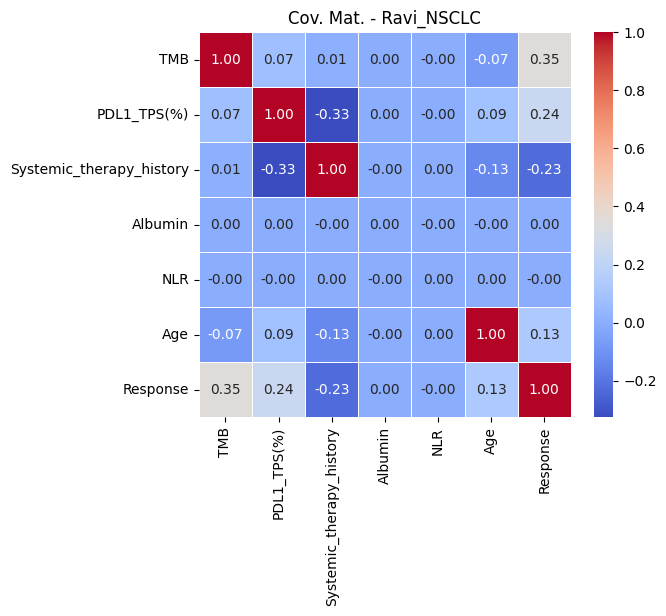

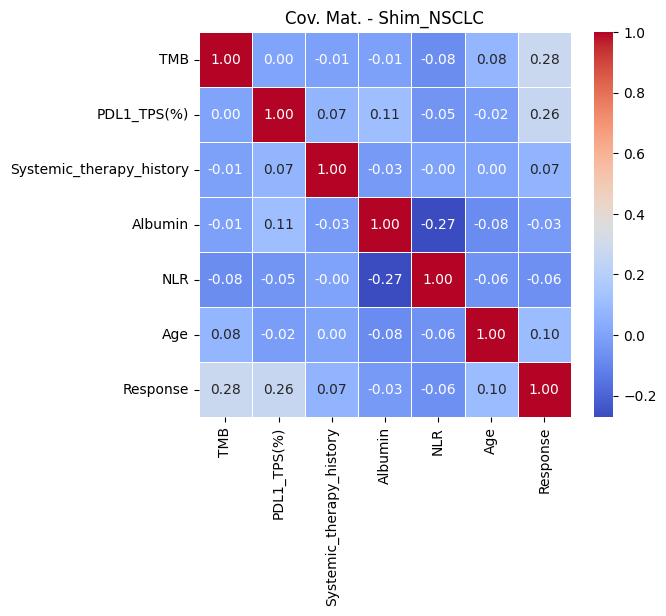

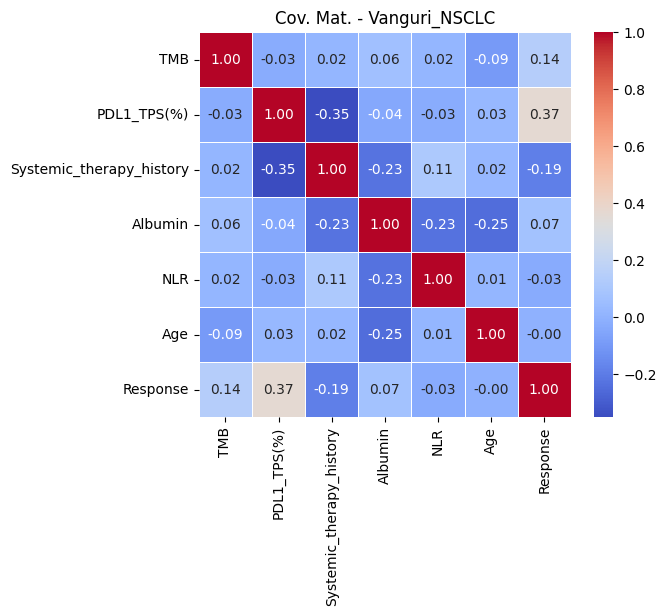

In [140]:
cancer_type_cols = [f'CancerType{i}' for i in range(1, 17)]

for i in range(3):
    aux_df = dfs[i].drop(cancer_type_cols, axis=1)
    aux_df = (aux_df - aux_df.mean()) / aux_df.std()
    cov_matrix = aux_df.cov()
    # print(cov_matrix)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Cov. Mat. - {nsclc_names[i]}")
    plt.show()